# Understanding `pycheops` using data of KELT-11 II: Preparing the dataset

In this notebook, we demonstrate preparing the dataset, including detrending (or decorrelating) the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 28 arcsec
UTC start:  2020-03-09T14:50:41
UTC end:    2020-03-10T04:44:34
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Number of non-flagged data points: 1535
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
C_cut = 39629816
N(C > C_cut) = 4
Mean counts = 39495521.5
Median counts = 39511341.9
RMS counts = 46070.5 [1166 ppm]
Median standard error = 6331.7 [160 ppm]
Median background = 358931 e-/pxl
Mean contamination = 40.4 ppm
Mean smearing correction = 19.4 ppm
Predicted amplitude of ramp = 71 ppm


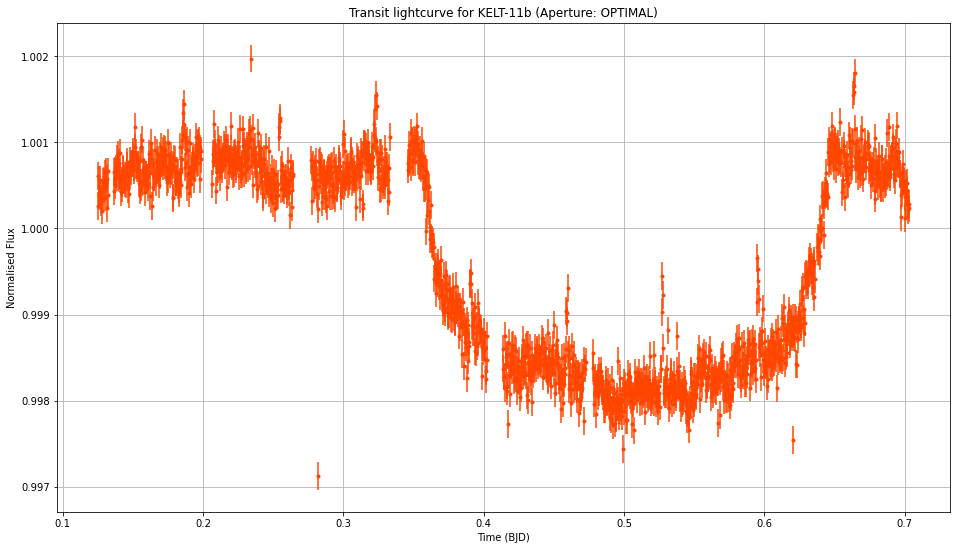

In [4]:
# Downloading data
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='OPTIMAL', decontaminate=True, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
# tim, fl, fle = dd.clip_outliers(clip=5)

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

## Detrending the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

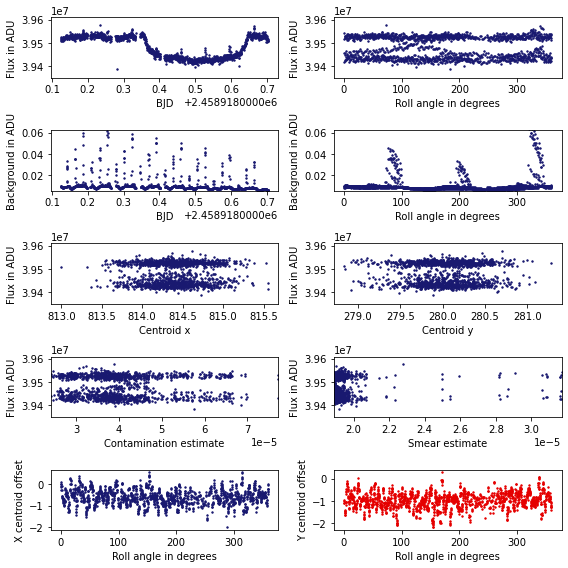

In [5]:
dd.diagnostic_plot()

In [7]:
# Run the decorrelation tool to assess if there are any trends in the data
# that should be removed.
dd.should_I_decorr()

Decorrelate in dfdt dfdx dfdy dfdsinphi dfdcosphi dfdbg dfdcontam dfdsmear d2fdt2 d2fdx2 d2fdy2 dfdsin2phi dfdcos2phi using decorr, lmfit_transt, or lmfit_eclipse functions.


(-21626.2084609026,
 ['dfdt',
  'dfdx',
  'dfdy',
  'dfdsinphi',
  'dfdcosphi',
  'dfdbg',
  'dfdcontam',
  'dfdsmear',
  'd2fdt2',
  'd2fdx2',
  'd2fdy2',
  'dfdsin2phi',
  'dfdcos2phi'])

We can see above that, `Dataset.should_I_decorr` function suggests that several decorrelations should be done.

### 